In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
COLORS = [(44/255, 160/255, 44/255, 1), 
          (255/255, 127/255, 14/255, 1), 
          (214/255, 39/255, 40/255, 1), 
          (31/255, 119/255, 180/255, 1)]

In [3]:
df = pd.read_csv('./out/database.csv')

In [4]:
total_partidas_jogo = df.groupby(['game']).agg({'game': ['count']})

In [5]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [6]:
winners = list()
for row in df['gid'].unique():
    winners.append(df[df['gid'] == row]['winner'].values[0])

In [7]:
games_by_players = df.groupby(['game', 'players']).agg({'players': ['count']})#.reset_index()
games_by_players.head()

players
                     count
game       players        
Bohnanza   Adriano       3
           Arturo        5
           David         3
           Isela         5
Encantados Adriano       2

In [8]:
total_games = games_by_players['players'].groupby(['players']).agg({'count': 'sum'})
total_games.head()

,count
players,
Adriano,16
Arturo,44
David,35
Isela,44


In [9]:
players_names = df['players'].unique()

total_efficience = dict()
hist_winners = dict()

for player in players_names:
    player_df = total_games.loc[player]['count']
    victories = len(list(
        filter(
            lambda i: i == player, winners
        )
    ))
    total_efficience[player] = (victories/player_df)*100
    hist_winners[player] = victories

In [10]:
game_efficience = dict(
    game = list(), player = list(), efficience = list()
)
for player in df['players'].unique():
    for game in df['game'].unique():
        vic = df.query("game == '{0}' and players == '{1}' and winner == '{1}'".format(game, player))
        try:
            par = games_by_players.loc[game].loc[player][0]
            game_efficience['game'].append(game)
            game_efficience['player'].append(player)
            game_efficience['efficience'].append((vic.count()[0]/par)*100)
        except KeyError:
            game_efficience['game'].append(game)
            game_efficience['player'].append(player)
            game_efficience['efficience'].append(0)

game_efficience = pd.DataFrame(game_efficience).astype({'efficience': int})
game_efficience.head()

,game,player,efficience
0,Lhama,David,57
1,Port Royal,David,28
2,Munchkin,David,0
3,Encantados,David,33
4,Saboteur,David,0


In [11]:
game_pivot = game_efficience.pivot("game", "player", "efficience")
game_pivot

player,Adriano,Arturo,David,Isela
game,,,,
Bohnanza,0,20,0,80
Encantados,0,75,33,0
Lhama,33,16,57,27
Munchkin,0,50,0,50
Ninja Camp,0,100,0,0
Port Royal,0,66,28,11
Saboteur,0,100,0,0


In [12]:
# Agregando la columna Game a game_pivot
idx = 0
new_col = ('Bohnanza','Encantados','Lhama','Munchkin','Ninja Camp','Port Royal','Saboteur')
game_pivot.insert(loc=idx, column='Game', value=new_col)
game_pivot

player,Game,Adriano,Arturo,David,Isela
game,,,,,
Bohnanza,Bohnanza,0,20,0,80
Encantados,Encantados,0,75,33,0
Lhama,Lhama,33,16,57,27
Munchkin,Munchkin,0,50,0,50
Ninja Camp,Ninja Camp,0,100,0,0
Port Royal,Port Royal,0,66,28,11
Saboteur,Saboteur,0,100,0,0


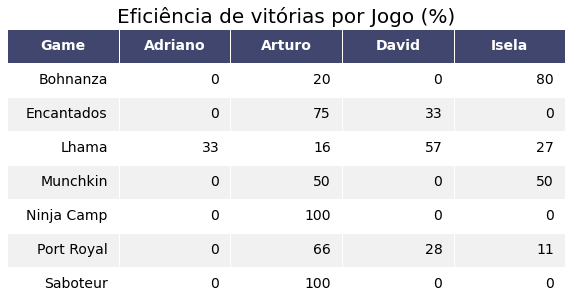

In [14]:
fig,ax = render_mpl_table(game_pivot, header_columns=0, col_width=2.0)
plt.title('Eficiência de vitórias por Jogo (%)')
fig.savefig("./fig/Eficiencia_por_jogo_table.png",facecolor='w',bbox_inches ='tight',pad_inches=0.1)

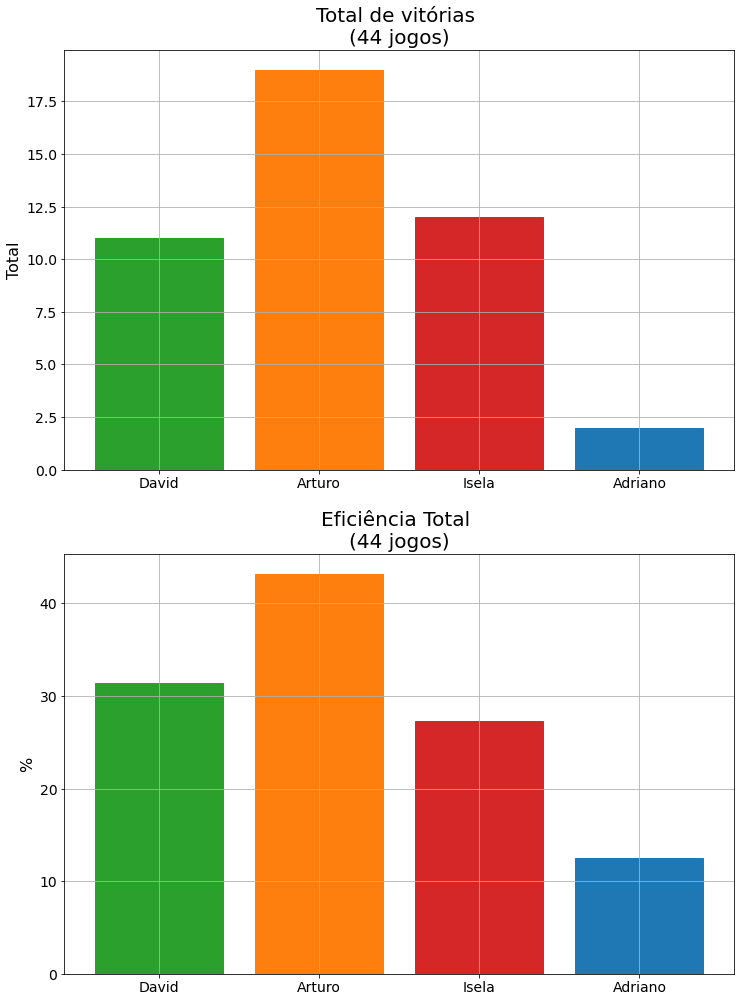

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 17))
ax[0].grid()
bars = ax[0].bar(hist_winners.keys(), hist_winners.values())
for i, color in enumerate(COLORS):
    bars[i].set_color(color)
ax[0].set_title('Total de vitórias \n(%d jogos)'%sum(hist_winners.values()))
ax[0].set_ylabel('Total')

ax[1].grid()
bars = ax[1].bar(total_efficience.keys(), total_efficience.values())
for i, color in enumerate(COLORS):
    bars[i].set_color(color)
ax[1].set_title('Eficiência Total \n(%d jogos)'%sum(hist_winners.values()))
ax[1].set_ylabel('%')

plt.savefig('./fig/general_statistics.png',facecolor='w',bbox_inches ='tight',pad_inches=0.1)

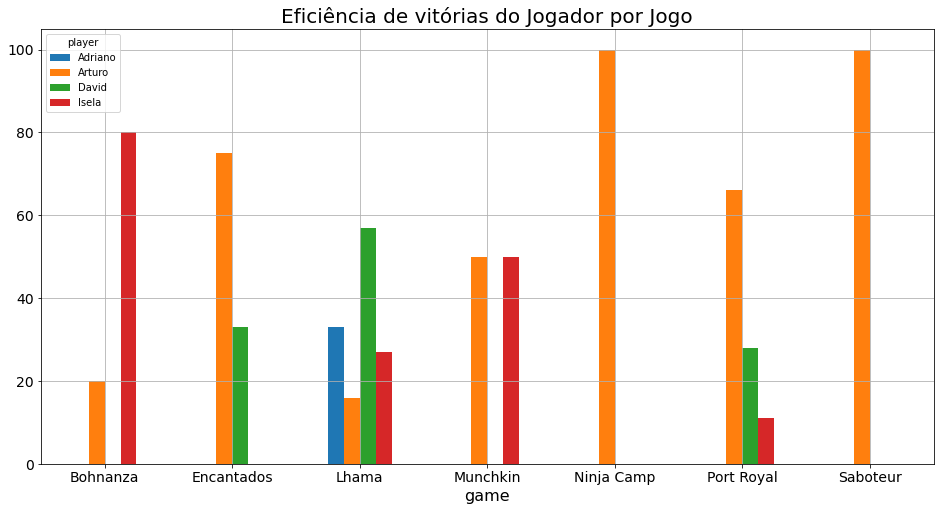

In [16]:
_, ax = plt.subplots(figsize=(16,8))
bars = game_pivot.plot(kind='bar', grid=True, ax=ax)
ax.tick_params(axis='x', rotation=0)
plt.title('Eficiência de vitórias do Jogador por Jogo')
plt.savefig("./fig/eficiencia_por_jogo.png",facecolor='w',bbox_inches ='tight',pad_inches=0.1)

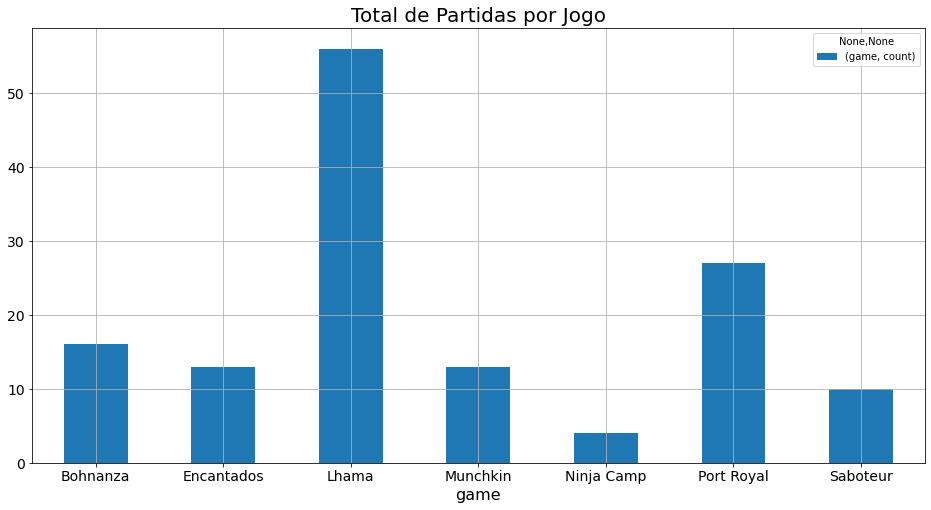

In [17]:
_, ax = plt.subplots(figsize=(16,8))
total_partidas_jogo.plot(kind='bar', grid=True, ax=ax)
ax.tick_params(axis='x', rotation=0)
plt.title('Total de Partidas por Jogo')
plt.savefig("./fig/Total_partidas.png",facecolor='w',bbox_inches ='tight',pad_inches=0.1)